### DCGAN that makes Bigger Images

like, 64x64 is cool and all but I want something better

In [53]:
import time
import random

import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.utils.data as tutils
import torchvision.utils as vutils
import torchvision.datasets as dset
import torchvision.transforms as transforms

import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import clear_output, display
%matplotlib inline

manualSeed = random.randint(1, 10000)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

print("Seed:", manualSeed)

Seed: 3903


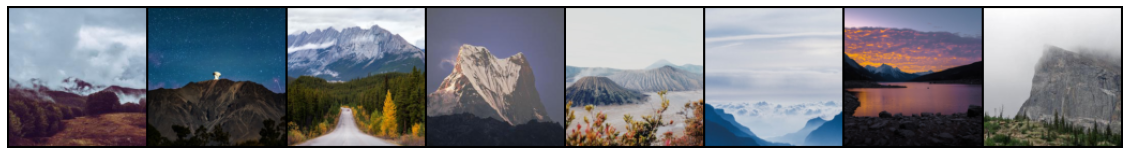

In [2]:
batch_size = 128
nc = 3          # number of channels
nz = 100        # size of input vector
ngf = 64        # generator: num features
ndf = 64        # discriminator: num features
img_size = 128  # edge size of the image

# Create the Datasets
transform = transforms.Compose(
    [
        transforms.Resize(img_size),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)
location = "../data/mountains"
#location = ""../data/betterMountains"
dataset_mountains = dset.ImageFolder(root=location, transform=transform)
dataloader_mountains = tutils.DataLoader(dataset_mountains, batch_size=batch_size, shuffle=True, num_workers=8)

real_batch = next(iter(dataloader_mountains))
plt.figure(figsize=(20,8))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:8], padding=2, normalize=True).cpu(), (1,2,0)));

In [3]:
cuda = True if torch.cuda.is_available() else False
device = 'cuda:0' if cuda else 'cpu'
print("Running On Cuda:", cuda)

Running On Cuda: True


In [4]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

        
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.ngpu = int(cuda)
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
            # state size. (ngf*16) x 4 x 4
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 8 x 8
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 16 x 16 
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 32 x 32
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 64 x 64
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 128 x 128
        )

    def forward(self, input):
        return self.main(input)

    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.ngpu = int(cuda)
        self.main = nn.Sequential(
            # input is (nc) x 128 x 128
            nn.Conv2d(nc, ndf, 4, stride=2, padding=1, bias=False), 
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 64 x 64
            nn.Conv2d(ndf, ndf * 2, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 32 x 32
            nn.Conv2d(ndf * 2, ndf * 4, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 16 x 16 
            nn.Conv2d(ndf * 4, ndf * 8, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 8 x 8
            nn.Conv2d(ndf * 8, ndf * 16, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*16) x 4 x 4
            nn.Conv2d(ndf * 16, 1, 4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [5]:
def train_loop(dataloader, netG, netD, epochs, verbose):
    criterion = nn.BCELoss()

    real_label = 1
    fake_label = 0
        
    optimizerD = torch.optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizerG = torch.optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

    G_losses = []
    D_losses = []
    iters = 0
  
    start_time = time.time()
    # Training Loop
    for epoch in range(epochs):       
        for i, data in enumerate(dataloader, 0):
            # DISCRIMINATOR
            # Train with all-real batch
            netD.zero_grad()
            real_cpu = data[0].to(device)
            b_size = real_cpu.size(0)
            label = torch.full((b_size,), real_label, device=device, dtype=torch.float)
            output = netD(real_cpu).view(-1)
            errD_real = criterion(output, label)
            errD_real.backward()
            
            # Train with all-fake batch
            noise = torch.randn(b_size, nz, 1, 1, device=device)
            fake = netG(noise)
            label.fill_(fake_label)
            
            output = netD(fake.detach()).view(-1)
            errD_fake = criterion(output, label)
            errD_fake.backward()
            errD = errD_real + errD_fake
            optimizerD.step()
            
            # GENERATOR
            netG.zero_grad()
            label.fill_(real_label)
            output = netD(fake).view(-1)
            errG = criterion(output, label)
            errG.backward()
            optimizerG.step()
            
            # Save Losses
            G_losses.append(errG.item())
            D_losses.append(errD.item())

            iters += 1
            
        if verbose:
            elapsed_time = time.time() - start_time
            estimated_time = (elapsed_time / (epoch + 1)) * (epochs - epoch + 1)
            print("Epoch %d/%d --- %.2fs elapsed --- %.2fs remaining     " % (epoch + 1, epochs, elapsed_time, estimated_time), end='\r')
    
    if verbose:        
        plt.figure(figsize=(10,5))
        plt.title("Generator and Discriminator Loss During Training")
        plt.plot(G_losses,label="G")
        plt.plot(D_losses,label="D")
        plt.xlabel("iterations")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

In [72]:
def show_results(real_images, fake_images):
    plt.figure(figsize=(20, 15))
    plt.axis("off")
    plt.title("Real Images")
    plt.imshow(np.transpose(vutils.make_grid(real_images, padding=2, normalize=True).cpu(), (1,2,0)))

    plt.figure(figsize=(20, 15))
    plt.axis("off")
    plt.title("Fake Images")
    plt.imshow(np.transpose(vutils.make_grid(fake_images, padding=2, normalize=True), (1,2,0)))
    
def train(dataloader, epochs, verbose=True):
    netG = Generator().to(device)
    netD = Discriminator().to(device)
    netG.apply(weights_init)
    netD.apply(weights_init)
    
    train_loop(dataloader, netG, netD, epochs, verbose)
    return netG

def un_normalize(tensor):
    inv_normalize = transforms.Normalize(mean=[-1, -1, -1], std=[2, 2, 2])
    inv_tensor = inv_normalize(tensor)
    im = np.transpose(inv_tensor, (1,2,0)).numpy()
    im = im * 255
    im = im.astype(np.uint8)
    return im

def get_images(generator, num_images):
    with torch.no_grad():
        return generator(torch.randn(num_images, nz, 1, 1, device=device)).detach().cpu()

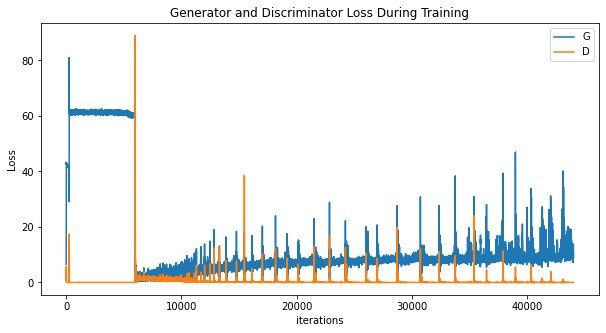

In [7]:
generator = train(dataloader_mountains, epochs=1000)

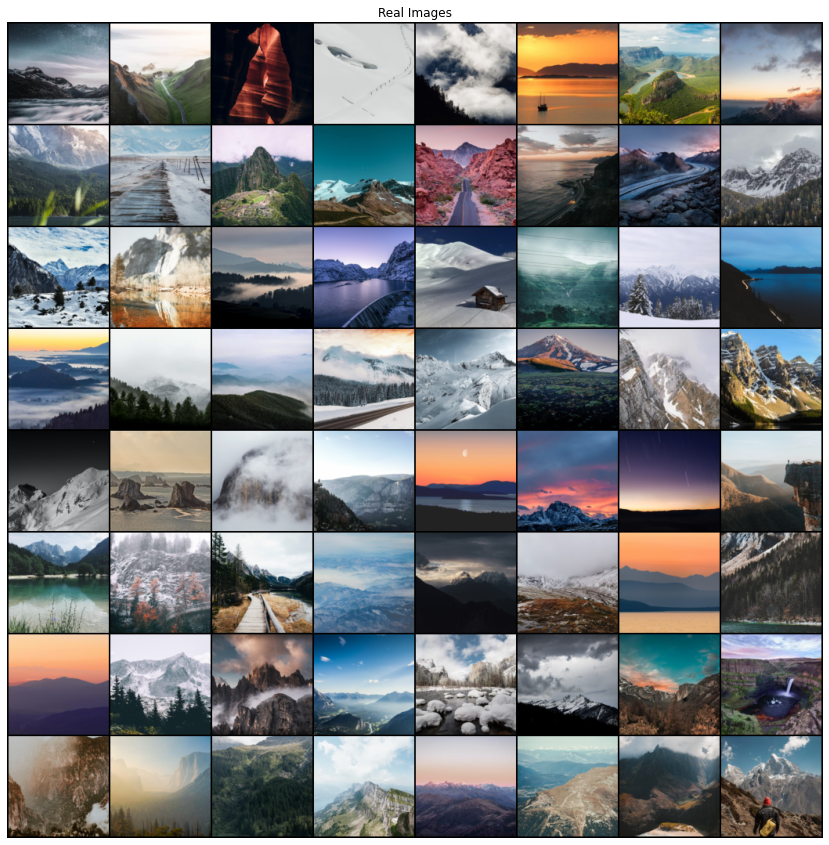

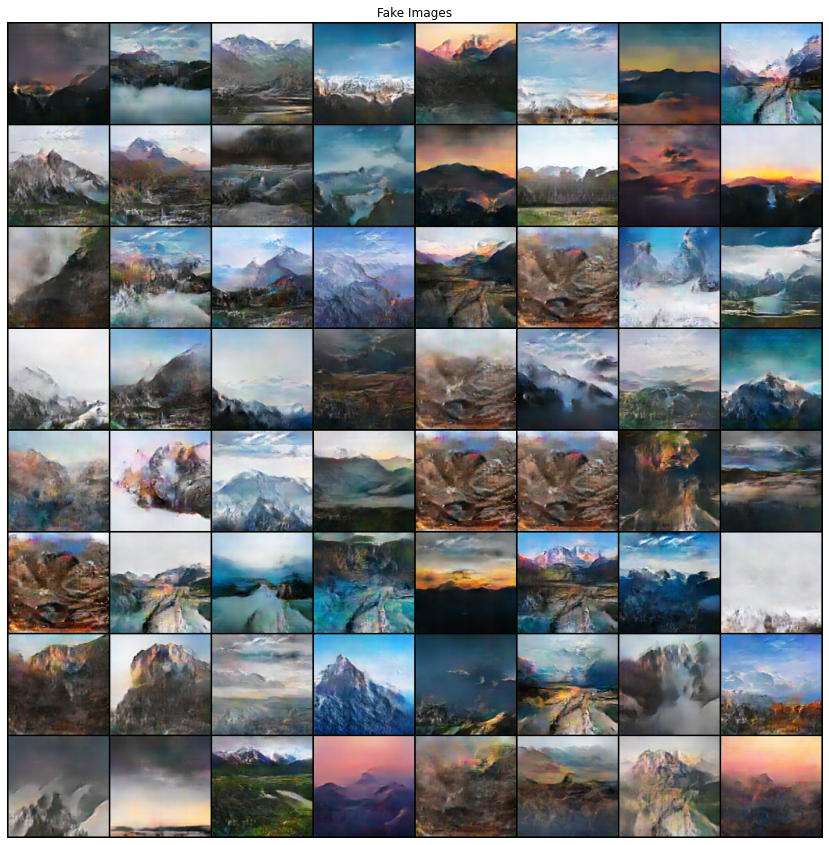

In [75]:
num_to_show = 64
real_images = next(iter(dataloader_mountains))[0][:num_to_show]
fake_images = get_images(generator, num_to_show)
show_results(real_images, fake_images)

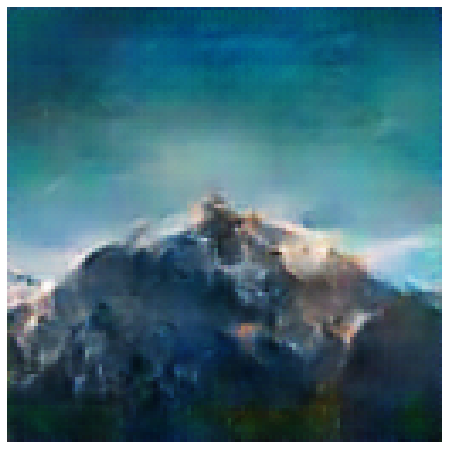

In [77]:
im = un_normalize(fake_images[31])

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.imshow(im)

Image.fromarray(im).save('fake.jpg')